In [229]:
import numpy as np
import pandas as pd 
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from statistics import mean

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Data Preparation

In [22]:
def load_data(in_path, name):
    df = pd.read_csv(in_path, low_memory=False)
    #print(f"{name}: shape is {df.shape}")
    #print(df.info())
    #display(df.head(5))
    return df

### Load Roster Data

In [23]:
DATA_DIR = "C:/Users/Owner/Documents/Class/DataViz/Final/data/rosters"
datasets={}

In [24]:
pre_roster_2009 = load_data(os.path.join(DATA_DIR, f'pre_roster_2009.csv'), 'pre_roster_2009')
pre_roster_2009['Made_Roster'] = 0

reg_roster_2009 = load_data(os.path.join(DATA_DIR, f'reg_roster_2009.csv'), 'reg_roster_2009')
reg_roster_2009['Made_Roster'] = 1

roster_2009 = reg_roster_2009.append(pre_roster_2009)

In [25]:
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

In [26]:
roster_all = roster_2009.copy()

for ii in years:
    pre_name = 'pre_roster_' + str(ii)
    pre_df = load_data(os.path.join(DATA_DIR, f'{pre_name}.csv'), pre_name)
    #print(pre_df.shape)
    
    reg_name = 'reg_roster_' + str(ii)
    reg_df = load_data(os.path.join(DATA_DIR, f'{reg_name}.csv'), reg_name)
    
    roster_df = pre_df.assign(Made_Roster=pre_df.gsis_id.isin(reg_df.gsis_id).astype(int))
    
    roster_all = roster_all.append(roster_df)
    #print(roster_all.shape)
    
roster_all = roster_all.drop(['season_type'], axis=1)

### Transform Play-By-Play Data

In [27]:
years.append(2009)

DATA_DIR = "C:/Users/Owner/Documents/Class/DataViz/Final/data/pbp"

In [28]:
columns = ['game_id', 'yardline_100', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'drive', 'qtr', 'down', 
           'goal_to_go', 'ydstogo', 'ydsnet', 'play_type', 'yards_gained','air_yards', 'yards_after_catch', 
           'two_point_converted', 'two_point_failed', 'third_down_converted', 'third_down_failed',
           'fourth_down_converted', 'fourth_down_failed', 'incomplete_pass', 'interception', 'penalty', 'fumble_lost',
           'touchdown', 'fumble', 'complete_pass', 'passer_player_id', 'receiver_player_id', 'rusher_player_id',
           'fumbled_1_player_id', 'penalty_player_id', 'penalty_yards',
           'unique_id', 'season', 'Two_Min', 'Redzone', 'Per_Yards_Gained', 'Success_Play']

In [29]:
pbp_all = pd.DataFrame(columns = columns)

for ii in years:
    pbp_name = 'pre_pbp_' + str(ii)
    pbp_df = load_data(os.path.join(DATA_DIR, f'{pbp_name}.csv'), pbp_name)
    
    #get unique ID for each play
    pbp_df['unique_id'] = pbp_df['play_id'].astype(str) + pbp_df['game_id'].astype(str)
    
    #add year of game
    pbp_df['season'] = ii
    
    #keep plays we are concerned with
    pbp_df = pbp_df[(pbp_df.play_type == 'pass') | (pbp_df.play_type == 'run')]
    
    #encode two point conversions
    two_conv_df = pbp_df[(pbp_df.two_point_conv_result == 'success')]
    pbp_df = pbp_df.assign(two_point_converted=pbp_df.unique_id.isin(two_conv_df.unique_id).astype(int))
    
    two_fail_df = pbp_df[(pbp_df.two_point_conv_result == 'failure')]
    pbp_df = pbp_df.assign(two_point_failed=pbp_df.unique_id.isin(two_fail_df.unique_id).astype(int))
    
    #flag plays in last two mins of a half
    two_min_df = pbp_df[(pbp_df.half_seconds_remaining <= 120)]
    pbp_df = pbp_df.assign(Two_Min=pbp_df.unique_id.isin(two_min_df.unique_id).astype(int))
    
    #flag red zone plays
    red_df = pbp_df[(pbp_df.yardline_100 <= 20)]
    pbp_df = pbp_df.assign(Redzone=pbp_df.unique_id.isin(red_df.unique_id).astype(int))
    
    
    # flag success rate using Football Outsider's varsity formula
    # https://www.footballoutsiders.com/info/glossary
    pbp_df['Per_Yards_Gained'] = pbp_df.yards_gained / pbp_df.ydstogo
    
    suc_fir_df = pbp_df[(pbp_df.down == 1) & (pbp_df.Per_Yards_Gained >= .5)]
    suc_sec_df = pbp_df[(pbp_df.down == 2) & (pbp_df.Per_Yards_Gained >= .7)]
    suc_thi_df = pbp_df[(pbp_df.down == 3) & (pbp_df.Per_Yards_Gained >= 1)]
    suc_fou_df = pbp_df[(pbp_df.down == 4) & (pbp_df.Per_Yards_Gained >= 1)]
    
    suc_all_df = pd.concat([suc_fir_df, suc_sec_df, suc_thi_df, suc_fou_df], axis=0, ignore_index=True)
    
    pbp_df = pbp_df.assign(Success_Play=pbp_df.unique_id.isin(suc_all_df.unique_id).astype(int))
    
    
    #prepare final dataframe
    pbp_df = pbp_df.fillna(0)
    
    pbp_all = pbp_all.append(pbp_df[columns])

### Combine All Data

In [30]:
agg_cols = ['yards_gained', 'two_point_converted', 'two_point_failed', 'third_down_converted', 'third_down_failed',
            'fourth_down_converted', 'fourth_down_failed', 'touchdown', 'Two_Min', 'Redzone', 'Success_Play', 'Total_Plays',
            'Q1_Plays', 'Q2_Plays', 'Q3_Plays', 'Q4_Plays']

pass_cols = ['interception', 'incomplete_pass', 'complete_pass', 'air_yards', 'pass_yards', 'pass_touchdown', 
             'Success_Pass', 'Passer_Plays'] + agg_cols

rec_cols = ['yards_after_catch', 'receiving_yards', 'receiving_touchdown', 'Success_Receive', 'Receiver_Plays'] + agg_cols

rush_cols = ['rush_yards', 'rush_touchdown', 'Success_Rush', 'Run_Plays'] + agg_cols

pen_cols = ['penalty', 'penalty_yards']

fumb_cols = ['fumble_lost', 'fumble']

In [31]:
all_cols = pass_cols + rec_cols + rush_cols + pen_cols + fumb_cols
all_cols = list(set(all_cols))
all_cols = sorted(all_cols, key=str.lower)

In [32]:
stats_df = pd.DataFrame(columns = all_cols)

for ii in years:
    year_df = pbp_all[(pbp_all.season == ii)].copy()
    year_df['Total_Plays'] = 1
    
    #Add Plays in quarter    
    q1_df = year_df[(year_df.qtr == 1)]
    year_df = year_df.assign(Q1_Plays=year_df.unique_id.isin(q1_df.unique_id).astype(int))
    
    q2_df = year_df[(year_df.qtr == 2)]
    year_df = year_df.assign(Q2_Plays=year_df.unique_id.isin(q2_df.unique_id).astype(int))
    
    q3_df = year_df[(year_df.qtr == 3)]
    year_df = year_df.assign(Q3_Plays=year_df.unique_id.isin(q3_df.unique_id).astype(int))
    
    q4_df = year_df[(year_df.qtr == 4)]
    year_df = year_df.assign(Q4_Plays=year_df.unique_id.isin(q4_df.unique_id).astype(int))
    
    #assemble passing stats
    pass_df = year_df[(year_df.play_type == 'pass')]
    pass_df = pass_df.infer_objects()  
    pass_df['pass_yards'] = pass_df['yards_gained']
    pass_df['pass_touchdown'] = pass_df['touchdown']
    pass_df['Success_Pass'] = pass_df['Success_Play']
    pass_df['Passer_Plays'] = 1
    
    pass_df = pass_df.groupby('passer_player_id').sum()    
    pass_df = pass_df[pass_cols]
    
    pass_df.index.name = 'player_id'
    
    
    #assemble receiving stats
    rec_df = year_df[(year_df.play_type == 'pass')]
    rec_df = rec_df.infer_objects()
    rec_df['receiving_yards'] = rec_df['yards_gained']
    rec_df['receiving_touchdown'] = rec_df['touchdown']
    rec_df['Success_Receive'] = rec_df['Success_Play']
    rec_df['Receiver_Plays'] = 1
    
    rec_df = rec_df.groupby('receiver_player_id').sum()    
    rec_df = rec_df[rec_cols]
    
    rec_df.index.name = 'player_id'
    rec_df = rec_df.drop(rec_df.index[0])
    
    
    #assemble rushing stats
    rush_df = year_df[(year_df.play_type == 'run')]
    rush_df = rush_df.infer_objects()
    rush_df['rush_yards'] = rush_df['yards_gained']
    rush_df['rush_touchdown'] = rush_df['touchdown']
    rush_df['Success_Rush'] = rush_df['Success_Play']
    rush_df['Run_Plays'] = 1
    
    rush_df = rush_df.groupby('rusher_player_id').sum()    
    rush_df = rush_df[rush_cols]
    
    rush_df.index.name = 'player_id'
    
    
    #assemble penalty stats
    pen_df = year_df[(year_df.penalty == 1)]
    pen_df = pen_df.infer_objects()
    
    pen_df = pen_df.groupby('penalty_player_id').sum()    
    pen_df = pen_df[pen_cols]
    
    pen_df.index.name = 'player_id'
    pen_df = pen_df.drop(pen_df.index[0])
    
    
    #assemble fumble stats
    fumb_df = year_df[(year_df.fumble == 1)]
    fumb_df = fumb_df.infer_objects()
    
    fumb_df = fumb_df.groupby('fumbled_1_player_id').sum()    
    fumb_df = fumb_df[fumb_cols]
    
    fumb_df.index.name = 'player_id'
    
    
    #combine stats
    comb_df = pd.concat([pass_df, rec_df, rush_df, pen_df, fumb_df]).groupby(['player_id']).sum()
    
    
    #join in player information
    player_df = roster_all[(roster_all.season == ii)]
    
    player_df = player_df.set_index('gsis_id')
    player_df.index.name = 'player_id'
    
    comb_df = comb_df.join(player_df)    
    comb_df = comb_df.dropna(subset=['Made_Roster'])
    
    
    #join all data into final dataframe
    comb_df = comb_df.fillna(0)
   
    stats_df = stats_df.append(comb_df)

In [33]:
#change the display formats on numbers for simplicity
pd.options.display.float_format = '{:,.0f}'.format
stats_df['season'] = pd.to_numeric(stats_df['season'], downcast='integer')

In [34]:
print(len(stats_df))
stats_df.head()

7292


,air_yards,complete_pass,fourth_down_converted,fourth_down_failed,fumble,fumble_lost,incomplete_pass,interception,pass_touchdown,pass_yards,...,two_point_converted,two_point_failed,yards_after_catch,yards_gained,season,full_player_name,abbr_player_name,team,position,Made_Roster
00-0000865,99,7,0,0,0,0,2,1,2,64,...,0,0,0,64,2010,Charlie Batch,C.Batch,PIT,QB,1
00-0002110,264,16,0,0,1,1,14,0,2,118,...,0,0,0,118,2010,Mark Brunell,M.Brunell,NYJ,QB,1
00-0003035,0,0,0,0,0,0,0,0,0,0,...,0,0,5,25,2010,Desmond Clark,D.Clark,CHI,TE,1
00-0003292,305,20,0,0,0,0,15,1,1,249,...,0,0,0,249,2010,Kerry Collins,K.Collins,TEN,QB,1
00-0003315,55,10,0,1,0,0,5,0,1,132,...,0,0,0,132,2010,Todd Collins,T.Collins,CHI,QB,1


## Visualizations

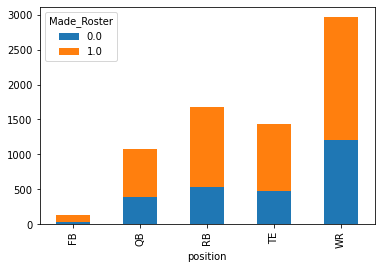

In [35]:
stats_df.groupby(['position', 'Made_Roster']).size().unstack().plot(kind='bar', stacked=True)

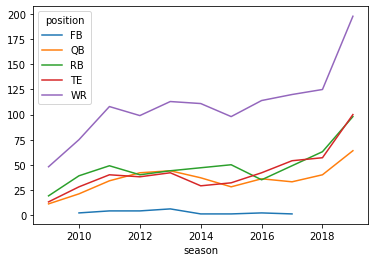

In [36]:
stats_df[stats_df['Made_Roster'] == 0].groupby(['season', 'position']).size().unstack().plot(kind='line')

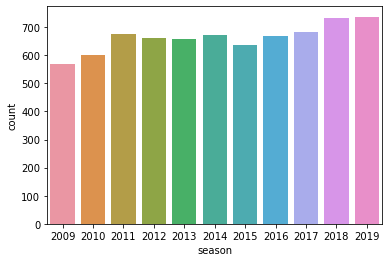

In [37]:
sns.countplot(x="season", data=stats_df);

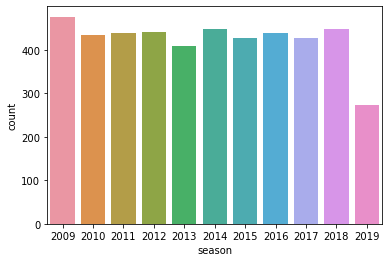

In [38]:
sns.countplot(x="season", data=stats_df[stats_df['Made_Roster'] == 1]);

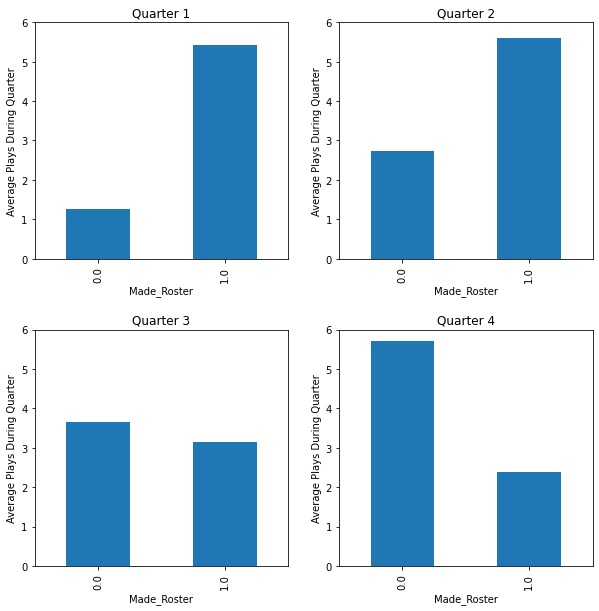

In [39]:
f = plt.figure(figsize=(10,10))

quarters = [1, 2, 3, 4]
for ii, jj in enumerate(quarters):
    plt.subplot(2,2,ii+1).set_ylim(0, 6)
    plt.title("Quarter " + str(jj))
    stats_df['Q' + str(jj) + '_Plays'].groupby(stats_df['Made_Roster']).mean().plot(kind='bar')
    plt.ylabel('Average Plays During Quarter')
    
f.subplots_adjust(hspace = .3)

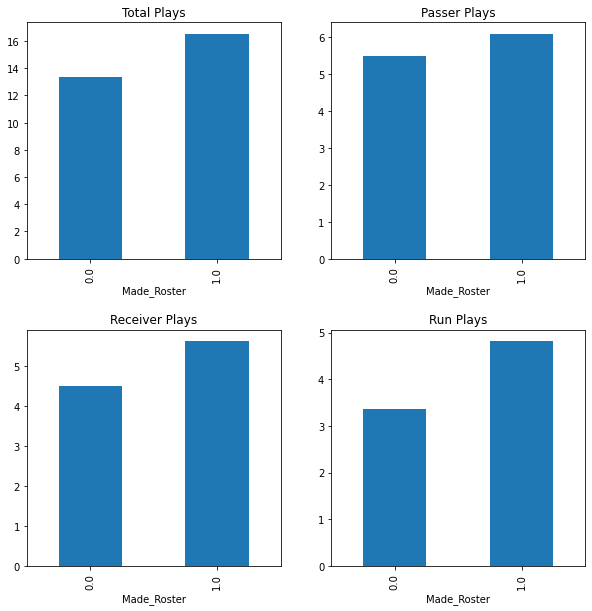

In [225]:
f = plt.figure(figsize=(10,10))

quarters = ['Total', 'Passer', 'Receiver', 'Run']
for ii, jj in enumerate(quarters):
    plt.subplot(2,2,ii+1)
    plt.title(str(jj) + ' Plays')
    stats_df[str(jj) + '_Plays'].groupby(stats_df['Made_Roster']).mean().plot(kind='bar')
    
f.subplots_adjust(hspace = .3)

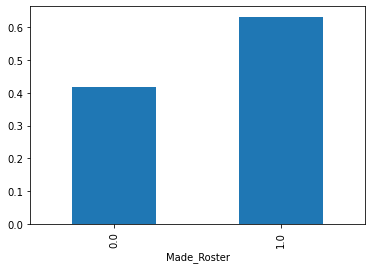

In [219]:
stats_df['touchdown'].groupby(stats_df['Made_Roster']).mean().plot(kind='bar')

## Prediction Model

### Prepare Data

In [98]:
X = stats_df.copy()
y = stats_df[['Made_Roster','season']]

ohe_df = pd.get_dummies(X.position)
X = pd.concat([X, ohe_df], axis=1).drop(columns=['Made_Roster',
                                                      'full_player_name', 'abbr_player_name', 'team', 'position'])

In [99]:
X_train = X[(X.season <= 2016)].drop(columns=['season'])
X_test = X[(X.season == 2017) | (X.season == 2018)].drop(columns=['season'])

y_train = y[(y.season <= 2016)].drop(columns=['season'])
y_test = y[(y.season == 2017) | (y.season == 2018)].drop(columns=['season'])

X = X.drop(columns=['season'])
y = y.drop(columns=['season'])

feature_names = list(X)

### Logistic Regression

In [243]:
logreg = LogisticRegression(solver='saga')
logreg.fit(X_train, y_train)

print(logreg.score(X_test, y_test))

0.7459421312632322


In [231]:
model_ftest = SelectKBest(score_func=f_classif, k='all')
model_ftest.fit(X_train, y_train)

SelectKBest(k='all', score_func=<function f_classif at 0x000001733E173598>)

In [232]:
ftest_scores = model_ftest.scores_
ftest_pvalues = model_ftest.pvalues_

In [233]:
ftest_all = pd.DataFrame(list(zip(feature_names, ftest_scores, ftest_pvalues)), columns=['feature', 'f value', 'p-value'])
ftest_all.sort_values('p-value').head(10)

,feature,f value,p-value
13,Q1_Plays,709,0
14,Q2_Plays,384,0
16,Q4_Plays,247,0
19,receiving_yards,210,0
36,yards_gained,194,0
26,Success_Receive,193,0
25,Success_Play,175,0
35,yards_after_catch,175,0
17,Receiver_Plays,154,0
30,Total_Plays,106,0


31


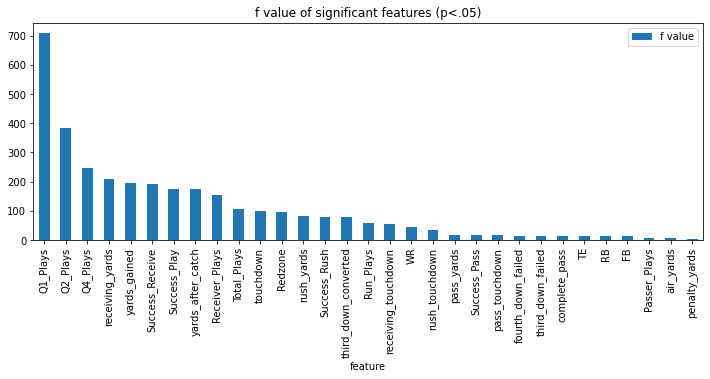

In [234]:
ftest_sig = ftest_all[ftest_all['p-value'] <= .05].sort_values('f value', ascending=False)
print(len(ftest_sig))
ftest_plot = ftest_sig.head(50)
ftest_plot.plot.bar(x='feature', y='f value', title='f value of significant features (p<.05)', figsize=(12,4))

In [235]:
f_model = SelectKBest(f_classif, k=31)
X_train_f = f_model.fit_transform(X_train, y_train)

logreg_f = LogisticRegression(solver='saga')
logreg_f.fit(X_train_f, y_train)

X_test_f = f_model.transform(X_test)

In [244]:
print(logreg_f.score(X_test_f, y_test))

0.739590684544813


In [237]:
X_train_qtr = X_train[['Q1_Plays', 'Q2_Plays', 'Q3_Plays', 'Q4_Plays']]
X_test_qtr = X_test[['Q1_Plays', 'Q2_Plays', 'Q3_Plays', 'Q4_Plays']]

In [245]:
logreg_qtr = LogisticRegression(solver='saga')
logreg_qtr.fit(X_train_qtr, y_train)

print(logreg_qtr.score(X_test_qtr, y_test))

0.7692307692307693


### Decision Tree

In [ ]:
tree = DecisionTreeClassifier(criterion = 'entropy')

In [246]:
tree_scores = []

for ii in range(1, 500):
    tree.fit(X_train, y_train)

    tree_scores.append(tree.score(X_test, y_test))
    
mean(tree_scores)

0.7192719949426022

In [247]:
tree_scores_f = []

for ii in range(1, 500):
    tree.fit(X_train_f, y_train)

    tree_scores_f.append(tree.score(X_test_f, y_test))
    
mean(tree_scores_f)

0.7244552619706598